In [1]:
from Subspace import Subspace
from Inference import Inference 
from model import Model
import matplotlib.pyplot as plt
from autograd import numpy as np
import CurveSubspace as curve
import util
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd

In [3]:
data = pd.read_csv('../example/hw7_data.csv')

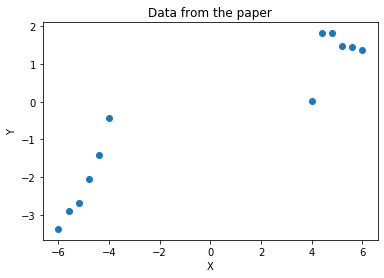

In [4]:
# visualize the data used in original paper
data = pd.read_csv('../example/hw7_data.csv')
x, y = data['x'].values, data['y'].values
plt.scatter(x, y)
plt.title('Data from the paper')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Create the Neural Network

In [11]:
alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c) ** 2)

###neural network model design choices

width = 7 #7
hidden_layers = 1 #2
input_dim = 1
output_dim = 1

architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': 'rbf',
                'activation_fn_params': 'c=0, alpha=1',
                'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y = 0.25)

# use MSE result as params_init
params = {'step_size': 1e-3, #1e-3
          'max_iteration': 5000, #5000
          'random_restarts': 1}

# fit my neural network to minimize MSE on the given data
#my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

## Curve Subspace

In [13]:
#width = 5
#hidden_layers = 2
net = curve.BaseNet(1, width, hidden_layers)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.MSELoss()

dataset = TensorDataset(torch.Tensor(x.reshape(-1, 1)), torch.Tensor(y))
loader = DataLoader(dataset, batch_size=64, shuffle = True)

# for training the two endpoints
#params_base = {'epochs': 1000}
params_base = params

In [14]:
def CurveNetGen(w0, w1):
    return curve.CurveNet(1, width, hidden_layers, w0, w1)

# for training the mid-points
params_curve = {'sample_size': 500}

In [15]:
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, loader = loader, params_base = params_base, 
                           optimizer = optimizer, criterion = criterion, 
                           curve_net_gen = CurveNetGen, params_curve = params_curve)
"""
my_subspace = Subspace.create(subspace_type="curve", net = net, params_base = params_base, nn = my_nn, 
                              X = x, y = y, loader = loader, criterion = criterion, 
                              curve_net_gen = CurveNetGen, params_curve = params_curve)

In [16]:
# change callback to control printing frequency (0 = no printing)
# epochs for training mid points
# restart: whether to get new endpoints or train on exisiting ones
my_subspace.collect_vector(epochs = 200, callback = 20, restart = False)
P, w = my_subspace.get_space()

[epoch 1] loss: 0.268
[epoch 21] loss: 0.265
[epoch 41] loss: 0.258
[epoch 61] loss: 0.256
[epoch 81] loss: 0.249
[epoch 101] loss: 0.245
[epoch 121] loss: 0.244
[epoch 141] loss: 0.240
[epoch 161] loss: 0.242
[epoch 181] loss: 0.236


## HMC

In [17]:
hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

inference_hmc = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=inference_hmc.P, w_hat=inference_hmc.w_hat)

In [18]:
begin=time.time()
inference_hmc.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.001
HMC 400: accept rate of 100.0 with step size 0.002499917406334249
HMC 600: accept rate of 100.0 with step size 0.003999054570374719
HMC 800: accept rate of 100.0 with step size 0.005499054570374719
HMC 1000: accept rate of 99.8 with step size 0.00699341695076016
HMC 1200: accept rate of 99.83333333333333 with step size 0.00849341695076016
HMC 1400: accept rate of 99.85714285714286 with step size 0.009982262758778115
HMC 1600: accept rate of 99.875 with step size 0.011482262758778115
HMC 1800: accept rate of 99.8888888888889 with step size 0.012981192206028233
HMC 2000: accept rate of 99.9 with step size 0.014481192206028233
HMC 2200: accept rate of 99.86363636363636 with step size 0.015931128794729233
HMC 2400: accept rate of 99.875 with step size 0.0174275337972958
HMC 2600: accept rate of 99.8076923076923 with step size 0.018927533797295802
HMC 2800: accept rate of 99.75 with step size 0.020409801978950672
HMC 3000: accept rate of 99

In [19]:
# get posterior z
n_sample = 100
post_sample = inference_hmc.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_hmc = my_nn.forward(P=P, w_hat=w.reshape(-1, 1), z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, 1, size = (100, 100))

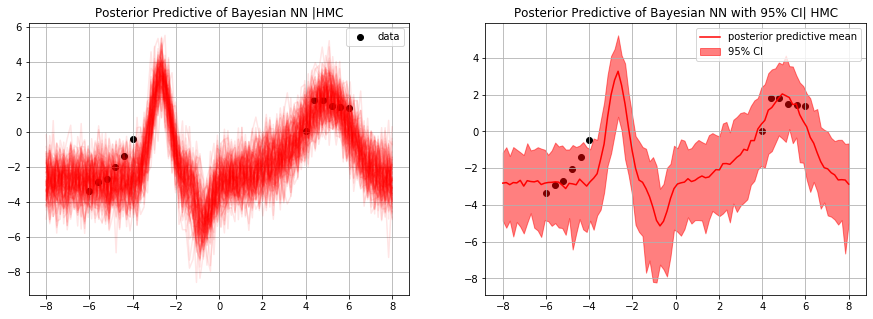

In [34]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_hmc[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_hmc.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_hmc, 0.25, axis=0), np.percentile(y_test_hmc, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI | HMC + curve')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

In [42]:
def plot_posterior_likelihood(my_inference,name,zx_range=[-0.2,0.2], zy_range=[-0.2,0.2]):
    zx=np.linspace(zx_range[0],zx_range[1],10)
    zy=np.linspace(zy_range[0],zy_range[1],10)
    zx,zy=np.meshgrid(zx,zy)
    z=np.array([zx,zy]).reshape(2,-1).T
    level = my_inference.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)
    post_z=my_inference.get_posterior(50)
    post_level=my_inference.get_posterior_likelihood(z=post_z,X=x,y=y)
    
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(zx,zy,level,cmap='Reds', edgecolor='none')
    ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
    plt.title('posterior log density ',fontsize=15)
    ax.set_xlabel('z 1')
    ax.set_ylabel('z 2')
    ax.set_zlabel('posterior log density')
    plt.legend(loc='lower left')
    ax1= fig.add_subplot(122)
    cs=ax1.contourf(zx, zy, level, levels=20, linewidths=1,cmap='Reds')
    ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
    fig.colorbar(cs, ax=ax1)
    plt.xlabel('z 1')
    plt.ylabel('z 2')
    plt.title('posterior log density ',fontsize=15)
    plt.legend()
    plt.suptitle(name, fontsize=20)

In [39]:
inference_hmc.w_hat=inference_hmc.w_hat.reshape(-1,1)

In [47]:
#plot_posterior_likelihood(my_inference=inference_hmc, name='curve+HMC',zx_range=[-10,-4], zy_range=[-10,-4])

## BBB

In [20]:
bbb_tune_params= {'step_size': 5e-3,
                                'S': 2000,
                                'max_iteration': 5000,
                                'checkpoint': 200,
                                'verbose': True,
                                'position_init': None,
                                  'random_restart':1,
                                'init_var': np.exp(-10)}

In [ ]:
inference_bbb = Inference.create(inference_type="BBB", model=my_nn, P=P, w_hat=w.reshape(-1, 1),  tune_params=bbb_tune_params,
                               Sigma_Z=25)

# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=inference_bbb.P, w_hat=inference_bbb.w_hat)

begin=time.time()
inference_bbb.train(X=x, y=y, warm_start=False, position_init=position_init,analytic_entropy=True, softplus=True)
end=time.time()

Iteration 0 lower bound -206.16360891732185; gradient mag: 29.4353582256122
Iteration 200 lower bound -178.62972330166906; gradient mag: 11.835888519145472
Iteration 400 lower bound -171.66747633886558; gradient mag: 7.1515400651709395
Iteration 600 lower bound -168.17838863306548; gradient mag: 5.5174227108342535
Iteration 800 lower bound -164.80665822668038; gradient mag: 5.808052609896872
Iteration 1000 lower bound -159.46524390115465; gradient mag: 8.082594597578712
Iteration 1200 lower bound -149.3747983799601; gradient mag: 10.083649499393829
Iteration 1400 lower bound -134.2789910955251; gradient mag: 17.633134149124412
Iteration 1600 lower bound -98.526733409102; gradient mag: 11.787056739545356
Iteration 1800 lower bound -96.04094150497782; gradient mag: 0.6054879205712922
Iteration 2000 lower bound -96.04380404885217; gradient mag: 0.2945712913597978
Iteration 2200 lower bound -96.01559697580151; gradient mag: 0.06658706990822943
Iteration 2400 lower bound -95.87584625365166;

In [26]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 28.98 min


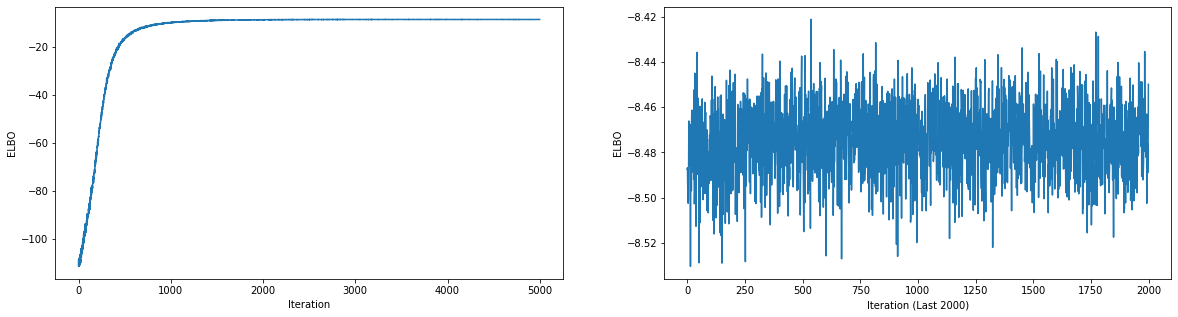

In [27]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(inference_bbb.ELBO)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('ELBO')

ax[1].plot(inference_bbb.ELBO[-2000:])
ax[1].set_xlabel('Iteration (Last 2000)')
ax[1].set_ylabel('ELBO');

In [28]:
# get posterior z
n_sample = 100
post_sample = inference_bbb.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))

In [ ]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

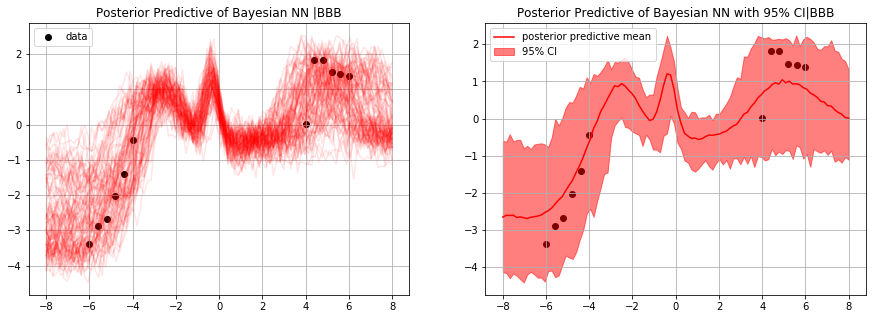

In [29]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

# Method
## Overview
We perform inference in a K-dimensional subspace $\mathcal{S}$ defined by 
\begin{aligned}
\mathcal{S} &= \{w|w = \hat{w} + z_1v_1 + \ldots + z_Kv_K\} \\
&= \{w|w = \hat{w} + Pz\}.
\end{aligned}
With a fixed $\hat{w}$ and projection matrix $P$, over which we perform inference, the free parameters of the model are now simply $z\in\mathbb{R}^K$. The new model thus has the likelihood function $$p(\mathcal{D}|z) = p_\mathcal{M}(\mathcal{D}|w = \hat{w} + Pz).$$ We can then perform Bayesian model averaging on new test data points $\mathcal{D}^*$, using the posterior over the parameters in the subspace:
\begin{aligned}
p(\mathcal{D}^*|\mathcal{D}) &= \int p_\mathcal{M}(\mathcal{D}^*|\tilde{w} = \hat{w} + Pz)p(z|\mathcal{D})\text{d}z \\
&\approx \frac{1}{J}\sum_{j=1}^Jp_\mathcal{M}(\mathcal{D}^*|\tilde{w} = \hat{w}+P\tilde{z}_j),\quad \tilde{z}_j \sim p(z|\mathcal{D}).
\end{aligned}

## Subspace Construction
In this section we will show various ways to construct subspace $\mathcal{S}$.
### 1. Random Subspaces
The basis $P$ is constructed by ranomly drawing $K$ vectors $v_1, \ldots, v_K \sim \mathcal{N}(0, I_p)$ in th weight space. We then rescale them to have norm 1. The shift vector is generated using the weights of a network pre-trained with stochastic weight averaging (SWA): $\hat{w} = w_{\text{SWA}}$. In particular, we run SGD with a high constant learning rate from a pre-trained solution, and form the average $w_{\text{SWA}} = \frac{1}{T}\sum_i w_i$ from the SGD iterates $w_i$.

### 2. PCA of the SGD Trajectory

### 3. Curve Subspaces
In this method, we find paths of near-constant low loss in the weight space between converged SGD solutions starting from different random initializations. Let $w_0, w_1$ be two sets of weights corresponding to the same neural network. Moreover, let $\phi_\theta: [0,1] \rightarrow \mathbb{R}^d$ be a continuous piecewise smooth parametric curve, with parameters $\theta$, such that $\phi_\theta(0) = w_0, \phi_\theta(1) = w_1$. To find a path of high accuracy between $w_0, w_1$, we propose to find parameters $\theta$ that minimize the expectation over a uniform distribution on the curve, $\hat{l}(\theta)$:
\begin{aligned}
\hat{l}(\theta) &= \frac{\int \mathcal{L}(\phi_\theta)\text{d}\phi_\theta}{\int\text{d}\phi_\theta} = \frac{\int_0^1\mathcal{L}(\phi_\theta(t))\|\phi_\theta^{'}(t)\|\text{d}t}{\int_0^1 \|\phi_\theta^{'}(t)\|\text{d}t} \\
&= \int_0^1 \mathcal{L}(\phi_\theta(t))q_\theta(t)\text{d}t = \mathbb{E}_{t\sim q_\theta(t)}\left[\mathcal{L}(\phi_\theta(t))\right],
\end{aligned}
where the distribution $q_\theta(t)$ on $t\in[0, 1]$ is defined as $q_\theta(t) := \|\phi_\theta^{'}(t)\|\cdot\left(\int_0^1 \|\phi_\theta^{'}(t)\|\text{d}t\right)^{-1}.$ Note that stochastic gradients of $\theta$ are generally intractable since $q_\theta(t)$ depends on $\theta$. Therefore we will use a more computationally tractable loss:
$$
l(\theta) = \int_0^1 \mathcal{L}(\phi_\theta(t))\text{d}t = \mathbb{E}_{t\sim U(0,1)}\mathcal{L}(\phi_\theta(t)).
$$
To minimize $l(\theta)$, at each iteration we sample $\tilde{t}$ from the unifrom distribution $U(0,1)$ and make a gradient step for $\theta$ with respect to the loss $\mathcal{L}(\phi_\theta(\tilde{t}))$. This way we can get unbiased estimates of the gradient of $l(\theta)$:
$$
\nabla_\theta\mathcal{L}(\phi_\theta(\tilde{t})) = \mathbb{E}_{t\sim U(0,1)} \nabla_\theta \mathcal{L}(\phi_\theta(t)) = \nabla_\theta \mathbb{E}_{t\sim U(0,1)} \mathcal{L}(\phi_\theta(t)) = \nabla_\theta l(\theta).
$$
Then we can perform gradient descent on $\theta$ to obtain the optimal curve.


In this work we employ the **Polygonal chain**. The trained weights $w_0$ and $w_1$ serve as the endpoints of the chain and the bends of the chain are the parameters $\theta$ of the curve parametrization. We only consider the simplest case of a chain with one bend $\theta$. Then
$$
\phi_\theta = \begin{cases} 2(t\theta + (0.5-t)w_0), & 0 \leq t \leq 0.5 \\
2((t-0.5)w_1 + (1-t)\theta), & 0.5 < t \leq 1. \end{cases}
$$